## 20220209 LeNet-1复现
## 学一点会一点

## 1. 导入需要的库

In [2]:
import torch
import torchvision
import torch.nn as nn 
import matplotlib.pyplot as plt 
import torch.utils.data as Data
import torch.nn.functional as F 
import torchvision.transforms as transforms


## 2. 数据准备

In [3]:
## 数据变换, 把数据转为tensor
trans_to_tensor = transforms.Compose([
    transforms.ToTensor()
])
## 下载训练集
data_train = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=trans_to_tensor,
    download=True
)
## 下载测试集
data_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=trans_to_tensor
)

In [4]:
## 看看数据
data_test
#data_train

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

tensor(6)

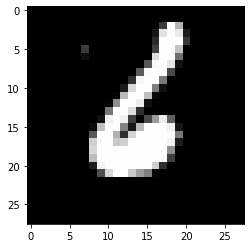

In [5]:
## DataLoader
train_loader = Data.DataLoader(data_train,batch_size=100,shuffle=True)
## 取出一张图像来可视化
image, label = next(iter(train_loader))
plt.imshow(image[0].squeeze(0), cmap='gray')
label[0]

## 3. 定义模型


In [6]:
## 定义模型
class LeNet1(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 4, 5) # 默认 stride=1, padding=0
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 12, 5)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(12*4*4, 10)

    def forward(self, x):
        out = torch.tanh(self.conv1(x))
        out = self.pool1(out)
        out = torch.tanh(self.conv2(out))
        out = self.pool2(out)
        out = out.view(-1, 12*4*4)
        out = self.fc1(out)

        return out

## 实例化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_net = LeNet1().to(device)

In [7]:
my_net

LeNet1(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=192, out_features=10, bias=True)
)

In [8]:
print(next(my_net.parameters()).device)

cuda:0


## 4. 定义损失函数和优化器


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_net.parameters(), lr=0.2)

## 5. 训练模型

In [135]:
## 定义模型训练的函数
def net_train(net, epoch=1, device='cuda'):
    net.train() # 设置为训练模式
    run_loss = 0 

    for num_epoch in range(epoch):
        print(f'This is the epoch : {num_epoch}')

        for i, data in enumerate(train_loader):
            images, labels = data[0], data[1]
            # 如果有cuda，把数据转移到gpu上
            # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            # print(device)
            images, labels = images.to(device), labels.to(device)


            outputs = net(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            run_loss = loss.item()

            if i % 100 ==99:
                print(f'训练进度：{(i+1) * 100}/ 60000 , loss = {run_loss/100}')
                loss = 0
                





In [10]:
## 为了更好的看到模型在测试集上的效果，我们定义一个测试集函数
def net_test(net, device='cuda'):
    net.eval()  # 转为测试模式

    ## 先定义测试数据的dataloader

    test_loader = Data.DataLoader(data_train, batch_size= 10000, shuffle=False)
    test_data = next(iter(test_loader))

    with torch.no_grad():
        images, labels = test_data[0], test_data[1]
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)

        pred = torch.max(outputs, 1)[1]
        print(f'test acc : {sum(pred == labels) / outputs.shape[0]}')
    
    net.train()

In [11]:
## 带测试集评估的模型训练

def net_train(net, epoch=1, device='cuda'):
    net.train() # 设置为训练模式
    run_loss = 0 

    for num_epoch in range(epoch):
        print(f'This is the epoch : {num_epoch}')

        for i, data in enumerate(train_loader):
            images, labels = data[0], data[1]
            # 如果有cuda，把数据转移到gpu上
            # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            # print(device)
            images, labels = images.to(device), labels.to(device)


            outputs = net(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            run_loss = loss.item()

            if i % 100 ==99:
                print(f'训练进度：{(i+1) * 100}/ 60000 , loss = {run_loss/100}')
                loss = 0
                
                net_test(net)



In [12]:
net_train(my_net, epoch= 10)

This is the epoch : 0
训练进度：10000/ 60000 , loss = 0.007613426446914673
test acc : 0.8319999575614929
训练进度：20000/ 60000 , loss = 0.0050237512588500975
test acc : 0.8833000063896179
训练进度：30000/ 60000 , loss = 0.003643186986446381
test acc : 0.8342999815940857
训练进度：40000/ 60000 , loss = 0.009537143111228942
test acc : 0.8799999952316284
训练进度：50000/ 60000 , loss = 0.006320258378982544
test acc : 0.8907999992370605
训练进度：60000/ 60000 , loss = 0.00590831995010376
test acc : 0.8958999514579773
This is the epoch : 1
训练进度：10000/ 60000 , loss = 0.00733074963092804
test acc : 0.8966999650001526
训练进度：20000/ 60000 , loss = 0.005839568972587586
test acc : 0.859499990940094
训练进度：30000/ 60000 , loss = 0.009758508801460265
test acc : 0.8769999742507935
训练进度：40000/ 60000 , loss = 0.0058060926198959355
test acc : 0.9293999671936035
训练进度：50000/ 60000 , loss = 0.004880451858043671
test acc : 0.8836999535560608
训练进度：60000/ 60000 , loss = 0.008725976347923279
test acc : 0.9246999621391296
This is the epoch : 2

In [13]:
# 在真正的测试集上看一下模型表现
test_batch = data_test.data.unsqueeze(1).to('cuda').float()
test_labels = data_test.targets.to('cuda')


In [14]:
test_outputs = my_net(test_batch)
test_pred = torch.max(test_outputs, 1)


In [15]:
print(f'test acc : {sum(test_pred[1] == test_labels) / test_labels.shape[0]}')

test acc : 0.9325999617576599


In [16]:
## 保存模型
torch.save(my_net, './LeNet1-mnist.pth') #保存模型